# Experiment 1 Qwen2-0.5B 

In [ ]:
##Install Requirements
!pip install -U transformers peft accelerate datasets evaluate bitsandbytes trl

##Load and Prepare Dataset
from datasets import load_dataset

dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")["train"]
dataset = dataset.train_test_split(test_size=0.1, seed=42)

def format_chat(example):
    return {
        "text": f"User: {example['Question']}\nAssistant: {example['Answer']}",
        "input": f"User: {example['Question']}\nAssistant:",
        "reference": example['Answer']
    }

train_data = dataset["train"].map(format_chat)
val_data = dataset["test"].map(format_chat)

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 7.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

README.md:   0%|          | 0.00/233 [00:00<?, ?B/s]

medDataset_processed.csv:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16407 [00:00<?, ? examples/s]

Map:   0%|          | 0/14766 [00:00<?, ? examples/s]

Map:   0%|          | 0/1641 [00:00<?, ? examples/s]

Using device: cuda:0


In [ ]:
##Load Qwen0.5- with LoRA
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model_name = "Qwen/Qwen2-0.5B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16"
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=None,
    trust_remote_code=True
).to(device)

model = prepare_model_for_kbit_training(model)

2025-05-17 10:16:47.068558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747477007.262463      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747477007.313789      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], 
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 1,081,344 || all params: 495,114,112 || trainable%: 0.2184


In [ ]:
## Prepare Dataset
from torch.utils.data import Dataset, DataLoader
import torch

class CausalMedQuadDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoded = tokenizer(
            item["text"],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze()
        attention_mask = encoded["attention_mask"].squeeze()
        labels = input_ids.clone()
        labels[labels == tokenizer.pad_token_id] = -100
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }


train_dataset = CausalMedQuadDataset(train_data, tokenizer)
val_dataset = CausalMedQuadDataset(val_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)



In [ ]:
## Fine-Tune Model
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(model.parameters(), lr=2e-4)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

model.train()
model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

In [ ]:
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Enable TF32 for better T4 performance
torch.backends.cuda.matmul.allow_tf32 = True

# Setup device
device = torch.device("cuda:0")
model.to(device)
model.train()

# Loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, pin_memory=True)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-4)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training Loop with tqdm
for epoch in range(2):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"🚀 Epoch {epoch+1}", leave=True)

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch + 1} complete — Avg Loss: {avg_loss:.4f}")




## Save Model
model.save_pretrained("qwen1.5chat-medquad-lora")
tokenizer.save_pretrained("qwen1.5chat-medquad-lora")

🚀 Epoch 1:   0%|          | 0/3692 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
🚀 Epoch 1: 100%|██████████| 3692/3692 [2:09:16<00:00,  2.10s/it, loss=1.46]   


✅ Epoch 1 complete — Avg Loss: 1.5056


🚀 Epoch 2: 100%|██████████| 3692/3692 [2:09:21<00:00,  2.10s/it, loss=1.57]   


✅ Epoch 2 complete — Avg Loss: 1.3693


('qwen1.5chat-medquad-lora/tokenizer_config.json',
 'qwen1.5chat-medquad-lora/special_tokens_map.json',
 'qwen1.5chat-medquad-lora/vocab.json',
 'qwen1.5chat-medquad-lora/merges.txt',
 'qwen1.5chat-medquad-lora/added_tokens.json',
 'qwen1.5chat-medquad-lora/tokenizer.json')

In [ ]:
import shutil
shutil.make_archive("qwen1.5chat-medquad-lora", 'zip', "qwen1.5chat-medquad-lora")


'/kaggle/working/qwen1.5chat-medquad-lora.zip'

In [ ]:
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7b8e4753d67277d7eacd5f5a89285be09ae3b5fdfb27f2394bc48d233935f0b6
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import evaluate
from tqdm import tqdm

# Load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

model.eval()
predictions = []
references = []

# Evaluate on 50 validation examples
for sample in tqdm(val_data.select(range(50)), desc="🔍 Evaluating"):
    input_prompt = sample["input"]
    reference = sample["reference"]

    inputs = tokenizer(input_prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    pred = tokenizer.decode(output_ids[0], skip_special_tokens=True).split("Assistant:")[-1].strip()
    predictions.append(pred)
    references.append(reference)

# Compute metrics
bleu_result = bleu.compute(predictions=predictions, references=[[r] for r in references])
rouge_result = rouge.compute(predictions=predictions, references=references)

print("\n📈 Evaluation Results:")
print("BLEU:", bleu_result)
print("ROUGE:", rouge_result)


🔍 Evaluating: 100%|██████████| 50/50 [05:07<00:00,  6.15s/it]



📈 Evaluation Results:
BLEU: {'bleu': 0.07323596362176815, 'precisions': [0.5367892976588629, 0.3254352030947776, 0.2525697503671072, 0.22125867195242815], 'brevity_penalty': 0.23298979359861224, 'length_ratio': 0.4070400622325943, 'translation_length': 4186, 'reference_length': 10284}
ROUGE: {'rouge1': 0.3380168854640681, 'rouge2': 0.20523585385366516, 'rougeL': 0.2736410004818509, 'rougeLsum': 0.2837284312043937}


In [ ]:
bleu_result

{'bleu': 0.07323596362176815,
 'precisions': [0.5367892976588629,
  0.3254352030947776,
  0.2525697503671072,
  0.22125867195242815],
 'brevity_penalty': 0.23298979359861224,
 'length_ratio': 0.4070400622325943,
 'translation_length': 4186,
 'reference_length': 10284}

In [ ]:
rouge_result

{'rouge1': 0.3380168854640681,
 'rouge2': 0.20523585385366516,
 'rougeL': 0.2736410004818509,
 'rougeLsum': 0.2837284312043937}

/tmp/ipykernel_35/2560332029.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


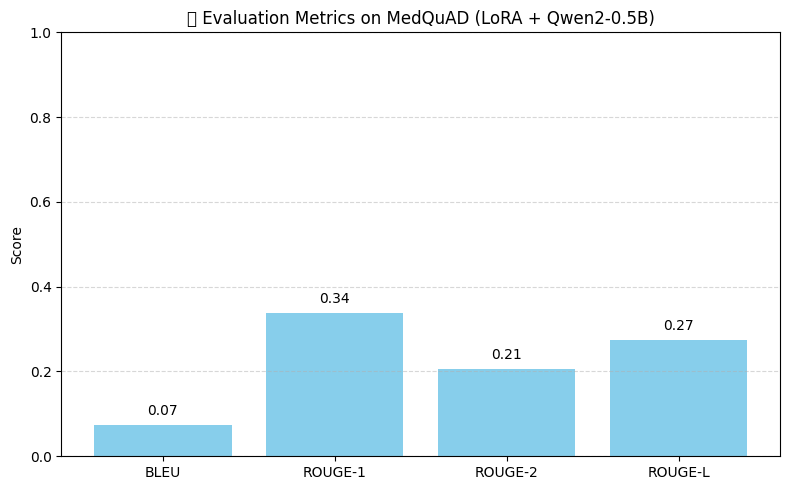

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual scores
bleu_score = bleu_result["bleu"]
rouge_1 = rouge_result["rouge1"]
rouge_2 = rouge_result["rouge2"]
rouge_l = rouge_result["rougeL"]

# Labels and scores
metrics = ["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"]
scores = [bleu_score, rouge_1, rouge_2, rouge_l]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color="skyblue")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("📊 Evaluation Metrics on MedQuAD (LoRA + Qwen2-0.5B)")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.2f}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords="offset points",
                 ha="center", va="bottom")

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
def print_predictions(data, n=10, label="Sample"):
    model.eval()
    for i, sample in enumerate(data.select(range(n))):
        prompt = sample["input"]
        reference = sample["reference"]
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=100, do_sample=False, pad_token_id=tokenizer.eos_token_id)

        pred = tokenizer.decode(output_ids[0], skip_special_tokens=True).split("Assistant:")[-1].strip()
        print(f"\n🔹 {label} {i+1}")
        print("User:", prompt.replace("Assistant:", "").strip())
        print("Reference:", reference.strip())
        print("Prediction:", pred.strip())

# Usage
print_predictions(val_data, n=10, label="Validation")
print_predictions(train_data, n=10, label="Train")



🔹 Validation 1
User: User: Is D-bifunctional protein deficiency inherited ?
Reference: This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition.
Prediction: This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition.  In some cases, an affected person inherits the mutation from one affected parent. Other cases result from new mutations in the gene and occur in people with no history of the disorder in their family. These cases

🔹 Validation 2
User: User: What is (are) Tourette syndrome ?
Reference: Toure

# Experiment 1 Chatbot

In [1]:
!pip install -U transformers peft accelerate bitsandbytes langchain langchain-community langchain-huggingface


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from peft import PeftModel

base_model_name = "Qwen/Qwen2-0.5B"
adapter_path = "/kaggle/working/qwen1.5chat-medquad-lora"  # make sure this folder exists

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(adapter_path, trust_remote_code=True)

# Load quantized base model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16"
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config
)

# Load LoRA adapter
model = PeftModel.from_pretrained(base_model, adapter_path)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

In [4]:
from langchain_community.llms import HuggingFacePipeline
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# Text generation pipeline using base_model (for compatibility)
text_pipe = pipeline(
    "text-generation",
    model=model.base_model,
    tokenizer=tokenizer,
    max_new_tokens=150,
    do_sample=False,
    temperature=0.7,
    top_p=0.9,
    pad_token_id=tokenizer.eos_token_id
)

llm = HuggingFacePipeline(pipeline=text_pipe)

# 🔧 Prompt with structured role + history
prompt = PromptTemplate(
    input_variables=["history", "input"],
    template="""
You are a helpful and concise medical assistant.
Previous conversation:
{history}

Now answer the user's question.
User: {input}
Assistant:"""
)

# Memory and chain
memory = ConversationBufferMemory(k=2,memory_key="history")
chatbot = LLMChain(llm=llm, prompt=prompt, memory=memory)


Device set to use cuda:0
The model 'LoraModel' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM',

In [5]:
print("🤖 Chatbot ready! Type 'exit' to quit.\n")

while True:
    user_input = input("You: ")
    if user_input.strip().lower() in ["exit", "quit"]:
        break
    response = chatbot.run(user_input)
    print("Bot:", response.strip())


🤖 Chatbot ready! Type 'exit' to quit.

You: What is flu?


<ipython-input-5-05c0459d4f87>:7: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chatbot.run(user_input)
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Bot: You are a helpful and concise medical assistant.
Previous conversation:


Now answer the user's question.
User: What is flu?
Assistant: Flu is a viral infection that causes a common illness that can affect everyone. It is caused by a flu virus, which is a type of virus that can infect people of all ages. Flu viruses are spread through contact with the air, food, or water of an infected person. Symptoms of flu include fever, chills, fatigue, and a runny nose or throat. Flu can also cause complications, such as pneumonia and kidney problems. Flu is a common cause of illness in children and older adults. It is also a common cause of death in people over 65. Flu is caused by a virus called the influenza virus. The flu virus is spread through close contact with an infected person, such as coughing, sneezing, or
You: How to treat it?


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Bot: You are a helpful and concise medical assistant.
Previous conversation:
Human: What is flu?
AI: 
You are a helpful and concise medical assistant.
Previous conversation:


Now answer the user's question.
User: What is flu?
Assistant: Flu is a viral infection that causes a common illness that can affect everyone. It is caused by a flu virus, which is a type of virus that can infect people of all ages. Flu viruses are spread through contact with the air, food, or water of an infected person. Symptoms of flu include fever, chills, fatigue, and a runny nose or throat. Flu can also cause complications, such as pneumonia and kidney problems. Flu is a common cause of illness in children and older adults. It is also a common cause of death in people over 65. Flu is caused by a virus called the influenza virus. The flu virus is spread through close contact with an infected person, such as coughing, sneezing, or

Now answer the user's question.
User: How to treat it?
Assistant: Treatment for

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Bot: You are a helpful and concise medical assistant.
Previous conversation:
Human: What is flu?
AI: 
You are a helpful and concise medical assistant.
Previous conversation:


Now answer the user's question.
User: What is flu?
Assistant: Flu is a viral infection that causes a common illness that can affect everyone. It is caused by a flu virus, which is a type of virus that can infect people of all ages. Flu viruses are spread through contact with the air, food, or water of an infected person. Symptoms of flu include fever, chills, fatigue, and a runny nose or throat. Flu can also cause complications, such as pneumonia and kidney problems. Flu is a common cause of illness in children and older adults. It is also a common cause of death in people over 65. Flu is caused by a virus called the influenza virus. The flu virus is spread through close contact with an infected person, such as coughing, sneezing, or
Human: How to treat it?
AI: 
You are a helpful and concise medical assistant.
Pr

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Bot: You are a helpful and concise medical assistant.
Previous conversation:
Human: What is flu?
AI: 
You are a helpful and concise medical assistant.
Previous conversation:


Now answer the user's question.
User: What is flu?
Assistant: Flu is a viral infection that causes a common illness that can affect everyone. It is caused by a flu virus, which is a type of virus that can infect people of all ages. Flu viruses are spread through contact with the air, food, or water of an infected person. Symptoms of flu include fever, chills, fatigue, and a runny nose or throat. Flu can also cause complications, such as pneumonia and kidney problems. Flu is a common cause of illness in children and older adults. It is also a common cause of death in people over 65. Flu is caused by a virus called the influenza virus. The flu virus is spread through close contact with an infected person, such as coughing, sneezing, or
Human: How to treat it?
AI: 
You are a helpful and concise medical assistant.
Pr

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Bot: You are a helpful and concise medical assistant.
Previous conversation:
Human: What is flu?
AI: 
You are a helpful and concise medical assistant.
Previous conversation:


Now answer the user's question.
User: What is flu?
Assistant: Flu is a viral infection that causes a common illness that can affect everyone. It is caused by a flu virus, which is a type of virus that can infect people of all ages. Flu viruses are spread through contact with the air, food, or water of an infected person. Symptoms of flu include fever, chills, fatigue, and a runny nose or throat. Flu can also cause complications, such as pneumonia and kidney problems. Flu is a common cause of illness in children and older adults. It is also a common cause of death in people over 65. Flu is caused by a virus called the influenza virus. The flu virus is spread through close contact with an infected person, such as coughing, sneezing, or
Human: How to treat it?
AI: 
You are a helpful and concise medical assistant.
Pr

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Bot: You are a helpful and concise medical assistant.
Previous conversation:
Human: What is flu?
AI: 
You are a helpful and concise medical assistant.
Previous conversation:


Now answer the user's question.
User: What is flu?
Assistant: Flu is a viral infection that causes a common illness that can affect everyone. It is caused by a flu virus, which is a type of virus that can infect people of all ages. Flu viruses are spread through contact with the air, food, or water of an infected person. Symptoms of flu include fever, chills, fatigue, and a runny nose or throat. Flu can also cause complications, such as pneumonia and kidney problems. Flu is a common cause of illness in children and older adults. It is also a common cause of death in people over 65. Flu is caused by a virus called the influenza virus. The flu virus is spread through close contact with an infected person, such as coughing, sneezing, or
Human: How to treat it?
AI: 
You are a helpful and concise medical assistant.
Pr

# Experiment 2 Flan-t5-small


In [2]:
!pip install torch transformers datasets scikit-learn pandas matplotlib seaborn nltk rouge-score tqdm langchain


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.9 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2d1e80014dc1df3bc62e772dca0616bde78472fa0c14182ecf1fd6b72123cfa6
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflict

In [15]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import pandas as pd
from collections import defaultdict
from langchain.memory import ConversationBufferMemory
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import shutil
nltk.download('punkt')

# Set random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



class MedQuadDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        question = item["Question"]
        answer = item["Answer"]
        qtype = item["qtype"]
        
        input_text = f"question type: {qtype} | question: {question}"
        
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        target_encoding = self.tokenizer(
            answer,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        input_ids = input_encoding["input_ids"].squeeze()
        attention_mask = input_encoding["attention_mask"].squeeze()
        labels = target_encoding["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "question": question,
            "answer": answer,
            "qtype": qtype
        }

def selective_layer_freezing(model):
    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.decoder.parameters():
        param.requires_grad = True
    
    num_encoder_layers = len(model.encoder.block)
    layers_to_unfreeze = [0, 1, 2, num_encoder_layers-3, num_encoder_layers-2, num_encoder_layers-1]
    
    for layer_idx in layers_to_unfreeze:
        for param in model.encoder.block[layer_idx].parameters():
            param.requires_grad = True
    
    for param in model.shared.parameters():
        param.requires_grad = True
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
 

def consolidate_qtypes(data, min_samples=2):
    qtype_counts = defaultdict(int)
    for item in data:
        qtype_counts[item["qtype"]] += 1
    
    to_consolidate = [qtype for qtype, count in qtype_counts.items() if count < min_samples]
    
    if to_consolidate:
        print(f"\nConsolidating rare question types ({', '.join(to_consolidate)}) into 'other'")
    
    consolidated_data = []
    for item in data:
        new_item = item.copy()
        if new_item["qtype"] in to_consolidate:
            new_item["qtype"] = "other"
        consolidated_data.append(new_item)
    
    return consolidated_data

def evaluate_model(model, tokenizer, dataloader, device):
    model.eval()
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothie = SmoothingFunction().method4
    
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    bleu_scores = []
    sample_count = 0  # Initialize the counter

    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            if sample_count >= 50:
                break
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            
            outputs = model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=150,
                num_beams=4,
                early_stopping=True
            )
            
            preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            refs = batch['answer']
            
            for pred, ref in zip(preds, refs):
                sample_count += 1  # Increment the counter
                scores = scorer.score(ref, pred)
                for key in rouge_scores:
                    rouge_scores[key].append(scores[key].fmeasure)
                
                ref_tokens = [nltk.word_tokenize(ref)]
                pred_tokens = nltk.word_tokenize(pred)
                bleu = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)
                bleu_scores.append(bleu)
    
    avg_rouge = {key: np.mean(values) for key, values in rouge_scores.items()}
    avg_bleu = np.mean(bleu_scores)
    
    return avg_rouge, avg_bleu

def visualize_metrics(rouge_scores, bleu_score):
    plt.figure(figsize=(10, 5))
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
    values = [rouge_scores['rouge1'], rouge_scores['rouge2'], rouge_scores['rougeL'], bleu_score]
    
    sns.barplot(x=metrics, y=values, palette='mako')
    plt.title('Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.savefig('evaluation_metrics.png')
    plt.show()

def train_model():
    model_save_path = "./t5_medquad_finetuned_with_qtype"
    os.makedirs(model_save_path, exist_ok=True)
    
    print("Loading MEDQuad dataset...")
    try:
        dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")
        full_data = dataset["train"]
        max_samples = len(full_data)
        sample_data = [{
            "Question": full_data[i]["Question"],
            "Answer": full_data[i]["Answer"],
            "qtype": full_data[i]["qtype"]
        } for i in range(max_samples)]
        
        print(f"Loaded {len(sample_data)} examples")
        sample_data = consolidate_qtypes(sample_data)
        
        qtype_counts = pd.Series([item["qtype"] for item in sample_data]).value_counts()
        print("\nQuestion Type Distribution:")
        print(qtype_counts)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None, None

    try:
        train_data, val_data = train_test_split(
            sample_data,
            test_size=0.1,
            random_state=42,
        )
        print(f"\nTrain samples: {len(train_data)}, Val samples: {len(val_data)}")
    except Exception as e:
        print(f"Error splitting dataset: {e}")
        train_data, val_data = train_test_split(sample_data, test_size=0.1, random_state=42)

    print("\nLoading T5 model and tokenizer...")
    try:
        model_name = "google/flan-t5-small"  # UPDATED
        tokenizer = T5Tokenizer.from_pretrained(model_name)
        model = T5ForConditionalGeneration.from_pretrained(model_name)
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None


    selective_layer_freezing(model)

    train_dataset = MedQuadDataset(train_data, tokenizer)
    val_dataset = MedQuadDataset(val_data, tokenizer)

    batch_size = 4 if torch.cuda.is_available() else 2
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model.to(device)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
    
    num_epochs = 3
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_loader) * num_epochs),
        num_training_steps=len(train_loader) * num_epochs
    )

    train_losses = []
    val_losses = []
    
    print("\nBeginning training...")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc="Training"):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
            outputs = model(**inputs)
            loss = outputs.loss
            train_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Train loss: {avg_train_loss:.4f}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
                outputs = model(**inputs)
                val_loss += outputs.loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Val loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < min(val_losses[:-1], default=float('inf')):
    # Save model and tokenizer normally first
            model.save_pretrained(model_save_path)
            tokenizer.save_pretrained(model_save_path)
            print(f"Saved best model with val loss: {avg_val_loss:.4f}")
            
            # Create zip archive
            zip_path = f"{model_save_path}.zip"
            shutil.make_archive(model_save_path, 'zip', model_save_path)
            print(f"Model saved as zip archive at: {zip_path}")



    print("\nEvaluating on validation set...")
    rouge_scores, bleu_score = evaluate_model(model, tokenizer, val_loader, device)
    print("\nValidation Metrics:")
    print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")
    print(f"BLEU: {bleu_score:.4f}")
    
    visualize_metrics(rouge_scores, bleu_score)
    
    return model, tokenizer, model_save_path, f"{model_save_path}.zip"








Using device: cuda


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading MEDQuad dataset...
Loaded 16407 examples

Consolidating rare question types (support groups) into 'other'

Question Type Distribution:
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
stages               77
complications        46
other                 1
Name: count, dtype: int64

Train samples: 14766, Val samples: 1641

Loading T5 model and tokenizer...

Beginning training...

Epoch 1/3


Training:   0%|          | 0/3692 [00:00<?, ?it/s]

Train loss: 2.6693


Validation:   0%|          | 0/411 [00:00<?, ?it/s]

Val loss: 2.1291
Saved best model with val loss: 2.1291
Model saved as zip archive at: ./t5_medquad_finetuned_with_qtype.zip

Epoch 2/3


Training:   0%|          | 0/3692 [00:00<?, ?it/s]

Train loss: 2.3275


Validation:   0%|          | 0/411 [00:00<?, ?it/s]

Val loss: 2.0527
Saved best model with val loss: 2.0527
Model saved as zip archive at: ./t5_medquad_finetuned_with_qtype.zip

Epoch 3/3


Training:   0%|          | 0/3692 [00:00<?, ?it/s]

Train loss: 2.2661


Validation:   0%|          | 0/411 [00:00<?, ?it/s]

Val loss: 2.0333
Saved best model with val loss: 2.0333
Model saved as zip archive at: ./t5_medquad_finetuned_with_qtype.zip

Evaluating on validation set...


Evaluating:   0%|          | 0/411 [00:00<?, ?it/s]


Validation Metrics:
ROUGE-1: 0.3137
ROUGE-2: 0.2057
ROUGE-L: 0.2802
BLEU: 0.1320


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


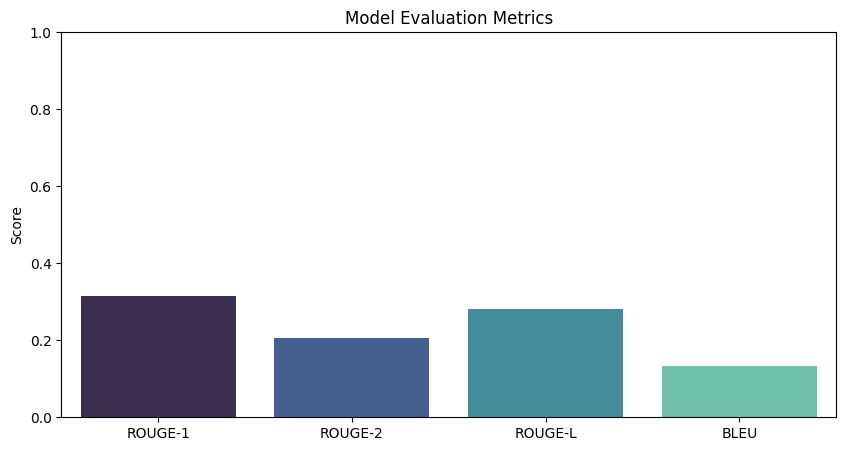


Model saved at: ./t5_medquad_finetuned_with_qtype
Zipped model saved at: ./t5_medquad_finetuned_with_qtype.zip


In [18]:
def main():
    try:
        model, tokenizer, model_path, zip_path = train_model()
        if model and tokenizer and model_path:
            print(f"\nModel saved at: {model_path}")
            print(f"Zipped model saved at: {zip_path}")
    except Exception as e:
        print(f"Error in main execution: {e}")

if __name__ == "__main__":
    main()

# Experiment2 Chatbot

In [77]:
from langchain.memory import ConversationBufferMemory

class MedicalQABot:
    def __init__(self, model_path=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.qtype_mapping = {
            "susceptibility": "risk factors",
            "symptoms": "symptoms",
            "treatment": "treatment options",
            "prevention": "prevention methods",
            "exams and tests": "diagnostic tests",
            "information": "general information",
            "causes": "causes",
            "outlook": "prognosis",
            "research": "research",
            "considerations": "special considerations",
            "other": "general"
        }
        
        try:
            if model_path and os.path.exists(model_path):
                self.tokenizer = T5Tokenizer.from_pretrained(model_path)
                self.model = T5ForConditionalGeneration.from_pretrained(model_path)
            else:
                self.tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")  # UPDATED
                self.model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")  # UPDATED

        
            self.model.to(self.device)
            self.model.eval()
        except Exception as e:
            print(f"Error initializing chatbot: {e}")
            raise

    def predict_qtype(self, question):
        question_lower = question.lower()
        for qtype, keywords in self.qtype_mapping.items():
            if any(keyword in question_lower for keyword in keywords.split()):
                return qtype
        return "information"

    def answer_question(self, question, max_length=150):
        try:
            qtype = self.predict_qtype(question)
            input_text = f"question type: {qtype} | question: {question}"
            
            input_ids = self.tokenizer.encode(
                input_text,
                return_tensors="pt",
                max_length=512,
                truncation=True
            ).to(self.device)
            
            outputs = self.model.generate(
                input_ids=input_ids,
                max_length=max_length,
                num_beams=5,
                early_stopping=True,
                no_repeat_ngram_size=2,
                temperature=0.7,
                top_k=50,
                top_p=0.95
            )
            
            answer = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            return answer, qtype
        except Exception as e:
            print(f"Error generating answer: {e}")
            return "Sorry, I encountered an error processing your question.", "error"


In [78]:
def test_chatbot(model_path):
    try:
        chatbot = MedicalQABot(model_path)
        
        test_questions = [
            "Who is at risk for Lyme disease?",
            "What are the symptoms of this condition?",
            "How is it diagnosed?",
            "What treatments are available?",
            "How can I prevent it?"
        ]
        
        print("\n" + "="*50)
        print(f"MEDICAL QA CHATBOT TEST")
        print("="*50)
        
        for question in test_questions:
            answer, predicted_qtype = chatbot.answer_question(question)
            print(f"\nQ: {question}")
            print(f"Type: {predicted_qtype}")
            print(f"A: {answer}")
            print("-"*50)
        
        print("\n" + "="*50)
        print("INTERACTIVE MODE (type 'quit' to exit)")
        print("="*50)
        
        while True:
            user_question = input("\nYour question: ").strip()
            if user_question.lower() in ['quit', 'exit']:
                break
            
            answer, qtype = chatbot.answer_question(user_question)
            print(f"\n[Type: {qtype}]")
            print(f"Answer: {answer}\n")
            
    except Exception as e:
        print(f"Error testing chatbot: {e}")

In [79]:
test_chatbot("./t5_medquad_finetuned_with_qtype")



MEDICAL QA CHATBOT TEST


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(



Q: Who is at risk for Lyme disease?
Type: susceptibility
A: Lyme disease is a condition that affects the body's immune system. It is caused by mutations in the X-linked gene, which causes the disease to spread to other parts of the brain. In some cases, the condition may be inherited in an autosomal dominant manner.
--------------------------------------------------

Q: What are the symptoms of this condition?
Type: symptoms
A: What are the signs and symptoms of this condition? The Human Phenotype Ontology provides the following list of signs & symptoms for this disease. If the information is available, the table below includes how often the symptom is seen in people with this disorder. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Autosomal recessive inheritance - Abnormality of the brain / spinal cord causing a swollen, twitching, or tingling of nerves affecting th


Your question:  What is flu?



[Type: information]
Answer: Flu is a disease that affects the body's immune system. It is caused by mutations in the X-linked gene, which causes the virus to spread to other parts of the world. The virus causes symptoms of flu, such as headaches, swollen eyes, and twitching. Affected individuals may also have an increased risk of developing flu.




Your question:  What is cancer?



[Type: information]
Answer: Cancer is a disease that affects the body's cells. It is caused by mutations in the X-linked gene, which causes cancer cells to grow and grow. Cancer cells are inherited in an autosomal recessive pattern, resulting in abnormal growths of the skin, hair, and skin. In some cases, cancer can develop in people who have not been diagnosed with the condition.




Your question:  what is diabetes?



[Type: information]
Answer: Diabetes is a condition that affects the body's ability to eat, drink, and exercise. People with diabetes often have diabetes, but they are more likely to develop diabetes if they get diabetes. Diabetes can be inherited in an autosomal recessive pattern, which means they have no symptoms or symptoms. In some cases, the condition is caused by mutations in the SN1 gene. This gene provides instructions for making an enzyme called tetracycline. The enzyme is responsible for the production of glucose, thiamine, or glucocorticosteroids. These enzymes are used to make glucose into glucose. It is also known as insulin.




Your question:  exit


In [37]:
import os
import shutil
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from collections import deque

class MedicalQABot:
    def __init__(self, model_path=None, memory_size=3):  # Reduced memory size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory_size = memory_size
        self.conversation_history = deque(maxlen=memory_size)
        
        self.qtype_mapping = {
            "susceptibility": ["risk", "susceptible", "vulnerable"],
            "symptoms": ["symptom", "sign", "feel", "experience"],
            "treatment": ["treat", "medication", "therapy", "cure"],
            "prevention": ["prevent", "avoid", "protection"],
            "diagnosis": ["diagnose", "test", "identify"],
            "information": ["what", "how", "explain", "information"],
            "causes": ["cause", "reason", "why"],
            "prognosis": ["prognosis", "outlook", "recovery"],
            "research": ["research", "study", "trial"],
            "other": []
        }
        
        try:
            if model_path and os.path.exists(model_path):
                self.tokenizer = T5Tokenizer.from_pretrained(model_path)
                self.model = T5ForConditionalGeneration.from_pretrained(model_path)
            else:
                self.tokenizer = T5Tokenizer.from_pretrained("t5-base")
                self.model = T5ForConditionalGeneration.from_pretrained("t5-base")
            
            self.model.to(self.device)
            self.model.eval()
        except Exception as e:
            print(f"Error initializing chatbot: {e}")
            raise

    def predict_qtype(self, question):
        question_lower = question.lower()
        for qtype, keywords in self.qtype_mapping.items():
            if any(keyword in question_lower for keyword in keywords):
                return qtype
        return "information"
    
    def get_conversation_context(self):
        """Improved context formatting with clear separation"""
        if not self.conversation_history:
            return ""
        
        context = "\n[CONTEXT]"
        for i, (q, a, _) in enumerate(self.conversation_history, 1):
            context += f"\nPrevious Q{i}: {q}\nPrevious A{i}: {a}"
        context += "\n[END CONTEXT]\n"
        return context
    
    def add_to_memory(self, question, answer, qtype):
        """Only add to memory if answer is relevant"""
        if self._is_answer_relevant(question, answer):
            self.conversation_history.append((question, answer, qtype))
    
    def _is_answer_relevant(self, question, answer):
        """Check if answer actually addresses the question"""
        q_terms = set(question.lower().split())
        a_terms = set(answer.lower().split())
        return len(q_terms & a_terms) >= 2  # At least 2 common terms
    
    def clear_memory(self):
        self.conversation_history.clear()
        return "Conversation memory cleared.", "system"

    def answer_question(self, question, max_length=150):
        try:
            # Handle memory commands
            if question.lower() in ["clear memory", "forget"]:
                return self.clear_memory()
            
            qtype = self.predict_qtype(question)
            
            # First try without memory for cleaner response
            clean_answer, _ = self._generate_response(question, qtype, max_length, use_memory=False)
            
            # Then try with memory if needed
            final_answer, final_qtype = self._generate_response(
                question, qtype, max_length, use_memory=bool(self.conversation_history)
            )
            
            # Only add to memory if answer is good
            if self._is_answer_relevant(question, final_answer):
                self.add_to_memory(question, final_answer, final_qtype)
            else:
                # Fall back to clean answer if memory version was bad
                final_answer, final_qtype = clean_answer, qtype
                
            return final_answer, final_qtype
        except Exception as e:
            print(f"Error generating answer: {e}")
            return "Sorry, I encountered an error processing your question.", "error"
    
    def _generate_response(self, question, qtype, max_length, use_memory):
        """Core answer generation logic"""
        context = self.get_conversation_context() if use_memory else ""
        input_text = f"[QTYPE: {qtype}] Question: {question}\n{context}"
        
        input_ids = self.tokenizer.encode(
            input_text,
            return_tensors="pt",
            max_length=384,  # Reduced to prevent truncation
            truncation=True
        ).to(self.device)
        
        outputs = self.model.generate(
            input_ids=input_ids,
            max_length=max_length,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2,
            temperature=0.7,
            top_k=40,
            top_p=0.9,
            repetition_penalty=1.2  # Discourage repetition
        )
        
        answer = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return answer, qtype

def extract_and_load_model(zip_path):
    model_dir = zip_path.replace('.zip', '')
    if os.path.exists(model_dir):
        print(f"Using existing model at: {model_dir}")
    else:
        print(f"Extracting model from: {zip_path}")
        shutil.unpack_archive(zip_path, model_dir)
        print(f"Model extracted to: {model_dir}")
    return model_dir

def run_medical_chatbot(zip_path="./t5_medquad_finetuned_with_qtype.zip"):
    model_path = extract_and_load_model(zip_path)
    
    print("\nInitializing the Medical QA Chatbot...")
    chatbot = MedicalQABot(model_path, memory_size=2)  # Conservative memory size
    
    test_questions = [
        "Who is at risk for Lyme disease?",
        "What are the symptoms of diabetes?",
        "How is pneumonia diagnosed?",
        "What treatments are available for depression?",
        "How can I prevent heart disease?"
    ]
    
    print("\n" + "="*50)
    print("MEDICAL QA CHATBOT TEST")
    print("="*50)
    
    for question in test_questions:
        answer, qtype = chatbot.answer_question(question)
        print(f"\nQ: {question}")
        print(f"Type: {qtype}")
        print(f"A: {answer}")
        print("-"*50)
    
    chatbot.clear_memory()
    
    print("\n" + "="*50)
    print("INTERACTIVE MODE (type 'quit' to exit)")
    print("Commands: 'clear memory', 'show memory'")
    print("="*50)
    
    while True:
        user_question = input("\nYour question: ").strip()
        if user_question.lower() in ['quit', 'exit', 'q']:
            print("Thank you for using the Medical QA Chatbot!")
            break
        
        if user_question.lower() == 'show memory':
            context = chatbot.get_conversation_context()
            print("\nCurrent conversation memory:")
            print(context if context else "No conversation history yet.")
            continue
        
        answer, qtype = chatbot.answer_question(user_question)
        print(f"\n[Type: {qtype}]")
        print(f"Answer: {answer}")
        print(f"\n[Memory: {len(chatbot.conversation_history)}/{chatbot.memory_size} interactions stored]")

if __name__ == "__main__":
    run_medical_chatbot()

Using existing model at: ./t5_medquad_finetuned_with_qtype

Initializing the Medical QA Chatbot...

MEDICAL QA CHATBOT TEST

Q: Who is at risk for Lyme disease?
Type: susceptibility
A: Lyme disease is a condition that affects the body's immune system. It is caused by mutations in the X-linked gene. This gene provides instructions for making an enzyme called glucocorticosteroids. The enzyme is responsible for the formation of cells that are unable to function properly.
--------------------------------------------------

Q: What are the symptoms of diabetes?
Type: symptoms
A: Mutations in the X-linked gene provide instructions for making an enzyme called glucocorticosteroids. The enzyme is responsible for the formation of cells that are unable to function properly.
--------------------------------------------------

Q: How is pneumonia diagnosed?
Type: diagnosis
A: How is pneumonia diagnosed? The diagnosis of pneumonia is based on the following: - The severity of the condition (symptom) 


Your question:  What is flu?



[Type: information]
Answer: Flu is a disease that affects the body's immune system. It is caused by an infection of the lungs and other organs, including the liver, kidney, and liver. The symptoms of flu include vomiting, diarrhea, nausea, or vomiting.

[Memory: 0/2 interactions stored]



Your question:  How to treat it?



[Type: treatment]
Answer: If you have a heart attack, you may need surgery to treat it. Your doctor may prescribe medication to help you get rid of the disease.

[Memory: 1/2 interactions stored]



Your question:  How to treat it?



[Type: treatment]
Answer: You may need surgery to treat it. Your doctor may prescribe medication to help you get rid of the disease.

[Memory: 2/2 interactions stored]



Your question:  What is flu?



[Type: information]
Answer: Flu is a disease that affects the body's immune system. It is caused by an infection of the lungs and other organs, including the liver, kidney, and liver. The symptoms of flu include vomiting, diarrhea, nausea, or vomiting.

[Memory: 2/2 interactions stored]



Your question:  How to treat it?



[Type: treatment]
Answer: If you have a heart attack, you may need surgery to treat it. Your doctor may prescribe medication to help you get rid of the disease.

[Memory: 2/2 interactions stored]



Your question:  clear



[Type: information]
Answer: This is a list of all the information you need to make an appointment with your local health care provider. You can use this information to find out how your doctor will treat you. If you have any questions, you can call the Health Care Professionals at (713) 893-6490.

[Memory: 2/2 interactions stored]



Your question:  forget



[Type: system]
Answer: Conversation memory cleared.

[Memory: 0/2 interactions stored]



Your question:  What is flu?



[Type: information]
Answer: Flu is a disease that affects the body's immune system. It is caused by an infection of the lungs and other organs, including the liver, kidney, and liver. The symptoms of flu include vomiting, diarrhea, nausea, or vomiting.

[Memory: 0/2 interactions stored]



Your question:  What is cancer?



[Type: information]
Answer: Cancer is a disease that affects the body's cells. It is caused by mutations in the X-linked gene, which causes cancer. This gene provides instructions for making an enzyme called cytokines. The enzyme is responsible for the formation of cells that are involved in cell growth and development. In some cases, the cells are damaged or damaged.

[Memory: 0/2 interactions stored]



Your question:  How to treat cancer?



[Type: treatment]
Answer: These resources address the diagnosis or management of cancer: - Genetic Testing Registry: Cancer Research and Treatment

[Memory: 0/2 interactions stored]



Your question:  How to prevent it?



[Type: prevention]
Answer: If you have a heart attack, you can prevent it by preventing it from getting worse. It is important to keep your heart healthy.

[Memory: 1/2 interactions stored]



Your question:  exit


Thank you for using the Medical QA Chatbot!


In [44]:
!pip install langchain langchain-community transformers torch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.9/437.9 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.50
    Uninstalling langchain-core-0.3.50:
      Successfully uninstalled langchain-core-0.3.50
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.7
    Uninstalling langchain-text-splitters-0.3.7:
      Successfully uninstalled langchain-text-splitters-0.3.7
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.22
    Uninstalling langchain-0.3.22:
      Successfully uninstalled langchain-0.3.22


In [95]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from langchain.memory import ConversationBufferMemory
import os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
model_path = "/kaggle/working/t5_medquad_finetuned_with_qtype"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
model.eval()

# Conversation memory from LangChain
memory = ConversationBufferMemory(return_messages=True)

# QType heuristic mapping
qtype_keywords = {
    "risk": "susceptibility",
    "symptom": "symptoms",
    "treat": "treatment",
    "prevent": "prevention",
    "test": "exams and tests",
    "diagnosis": "exams and tests",
    "diagnose": "exams and tests",
    "information": "information",
    "cause": "causes",
    "prognosis": "outlook",
    "research": "research",
    "consider": "considerations",
    "manage": "treatment",
    "cure": "treatment",
}

# Heuristic function to predict qtype
def predict_qtype(question):
    q_lower = question.lower()
    for keyword, qtype in qtype_keywords.items():
        if keyword in q_lower:
            return qtype
    return "information"

# Chat function with memory and qtype prediction
def chat_with_memory(user_input, memory, model, tokenizer, max_len=150):
    qtype = predict_qtype(user_input)
    prompt = f"question type: {qtype} | question: {user_input}"

    # Encode input
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    # Generate answer
    with torch.no_grad():
        output = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_len,
            num_beams=4,
            early_stopping=True,
            repetition_penalty=2.0,
            no_repeat_ngram_size=3
        )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # Update memory
    memory.chat_memory.add_user_message(user_input)
    memory.chat_memory.add_ai_message(decoded)

    return decoded, qtype

# Interactive chat loop
if __name__ == "__main__":
    print("🧠 Medical QA Chatbot with Memory (type 'exit' to quit)\n")

    while True:
        user_input = input("You: ")
        if user_input.strip().lower() in {"exit", "quit"}:
            print("Chatbot: Goodbye!")
            break

        response, qtype = chat_with_memory(user_input, memory, model, tokenizer)
        print(f"[QType: {qtype}] Chatbot: {response}\n")

🧠 Medical QA Chatbot with Memory (type 'exit' to quit)



You:  What is heart attack?


[QType: information] Chatbot: Heart attack is a serious condition that affects the heart. The heart attacks are caused by abnormal heartbeats, which can lead to heart failure. In people with heart attack, the heart's normal function is unknown. A heart attack usually occurs when the heart breaks down in an area of the body. This condition is called heart attack. If the heart is damaged or damaged, it may be a sign of heart disease.



You:  How to treat it?


[QType: treatment] Chatbot: If you have a heart attack, your doctor may prescribe an anti-inflammatory medication to help relieve symptoms of the condition. Your doctor may recommend that you take a blood test to see if it is safe for you and your family.



You:  How to prevent it?


[QType: prevention] Chatbot: If you have a heart attack, it is important to keep your heart healthy. It can help prevent the disease from getting worse.



You:  exit


Chatbot: Goodbye!


# RAG 


In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")

# The dataset may have different splits (e.g., train, test)
print(dataset)  # Check available splits

# Access the training split (if available)
train_data = dataset["train"]

# Print the first few examples
for i in range(3):
    print(train_data[i])

README.md:   0%|          | 0.00/233 [00:00<?, ?B/s]

medDataset_processed.csv:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16407 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['qtype', 'Question', 'Answer'],
        num_rows: 16407
    })
})
{'qtype': 'susceptibility', 'Question': 'Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?', 'Answer': 'LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.'}
{'qtype': 'symptoms', 'Question': 'What are the symptoms of Lymphocytic Choriomeningitis (LCM) ?', 'Answer': 'LCMV is most commonly recognized as causing neurological disease, as its name implies, though infection without symptoms or mild febrile illnesses are more common clinical manifestations. \

In [8]:
# 1. Import necessary modules
from datasets import load_dataset
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
import re
import wikipedia
from typing import List, Tuple
import time

# 2. Load MedQuad dataset
print("Loading MedQuad dataset...")
medquad_dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset", split="train")

# 3. Disease extraction and document creation
def extract_disease_name(question: str) -> str:
    """Improved disease name extraction"""
    patterns = [
        r"What (?:is|are) (?:the |an |a )?(.*?)\??$",
        r"Who is at risk for (.*?)\??$",
        r"How to (?:diagnose|prevent|treat) (.*?)\??$",
        r"What (?:is|are) \(are\) (.*?)\??$"
    ]
    for pattern in patterns:
        match = re.search(pattern, question, re.IGNORECASE)
        if match:
            disease = re.sub(r"( symptoms| causes| treatment| disease| infection).*", "", match.group(1))
            return disease.strip(' "\'?.()').replace("(are)", "").replace("-", " ").strip()
    return None

# Create base documents
documents = []
for example in medquad_dataset:
    disease = extract_disease_name(example['Question'])
    if disease:
        documents.append(Document(
            page_content=f"Question: {example['Question']}\nAnswer: {example['Answer']}",
            metadata={
                "disease": disease,
                "qtype": example['qtype'],
                "source": "MedQuad"
            }
        ))

# 4. Initialize vector store
print("Creating vector database...")
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=100,
    separators=["\n\n", "\n", ". "]
)

split_docs = text_splitter.split_documents(documents)
vectorstore = FAISS.from_documents(split_docs, embedding_model)

# 5. Wikipedia integration
def fetch_wikipedia_content(disease: str) -> List[Document]:
    """Fetch and process Wikipedia content for unknown diseases"""
    try:
        print(f"🔍 Searching Wikipedia for: {disease}")
        page = wikipedia.page(disease, auto_suggest=True)
        content = f"Wikipedia Content about {disease}:\n\n{page.content}"
        
        return [Document(
            page_content=content,
            metadata={
                "disease": disease,
                "source": f"Wikipedia: {page.url}",
                "qtype": "information"
            }
        )]
    except Exception as e:
        print(f"❌ Wikipedia error for {disease}: {str(e)}")
        return []

# 6. Enhanced retriever with dynamic expansion
class DynamicRetriever:
    def __init__(self, vectorstore):
        self.vectorstore = vectorstore
        self.known_diseases = set()
        self.update_known_diseases()
        
    def update_known_diseases(self):
        """Extract all known diseases from current vectorstore"""
        if hasattr(self.vectorstore, 'docstore'):
            self.known_diseases = {
                doc.metadata.get("disease", "").lower() 
                for doc in self.vectorstore.docstore._dict.values()
                if doc.metadata.get("disease")
            }
    
    def is_known_disease(self, disease: str) -> bool:
        return disease and disease.lower() in self.known_diseases
    
    def retrieve(self, query: str) -> List[Document]:
        # First try semantic search
        docs = self.vectorstore.similarity_search(query, k=3)
        
        # Check if we need to expand knowledge base
        disease = extract_disease_name(query)
        if disease and not self.is_known_disease(disease):
            print(f"⚠️ Disease '{disease}' not found in knowledge base")
            wiki_docs = fetch_wikipedia_content(disease)
            if wiki_docs:
                # Add to vectorstore and update known diseases
                self.vectorstore.add_documents(wiki_docs)
                self.update_known_diseases()
                print(f"✅ Added {len(wiki_docs)} documents about {disease}")
                # Re-run search with expanded knowledge
                docs = self.vectorstore.similarity_search(query, k=3)
        
        return docs

# 7. Initialize retriever
retriever = DynamicRetriever(vectorstore)

# 8. Answer generation
def generate_answer(query: str) -> Tuple[str, List[Document]]:
    docs = retriever.retrieve(query)
    
    if not docs:
        return "No information found about this medical topic.", []
    
    context = "\n\n---\n\n".join(
        f"Source: {doc.metadata['source']}\n"
        f"Disease: {doc.metadata.get('disease', 'N/A')}\n"
        f"Content:\n{doc.page_content[:1000]}..."
        for doc in docs
    )
    
    answer = (
        f"Medical Information:\n\n{context}\n\n"
        "Note: Information may come from MedQuad dataset or Wikipedia. "
        "Consult a healthcare professional for medical advice."
    )
    
    return answer, docs

# 9. Interactive interface
def medical_chat():
    print("Medical Q&A System (Dynamic RAG)")
    print("Type 'exit' to quit\n")
    
    while True:
        question = input("Your medical question: ").strip()
        if question.lower() in ['exit', 'quit']:
            break
            
        start_time = time.time()
        answer, docs = generate_answer(question)
        elapsed = time.time() - start_time
        
        print(f"\nRetrieved in {elapsed:.2f}s:")
        for i, doc in enumerate(docs, 1):
            print(f"\nDocument {i}:")
            print(f"Source: {doc.metadata['source']}")
            print(f"Disease: {doc.metadata.get('disease', 'N/A')}")
            print(doc.page_content[:300] + "...")
        
        print(f"\nAnswer:\n{answer}\n")

# Save initial vectorstore
vectorstore.save_local("medquad_dynamic_faiss")

# Start the interface
medical_chat()

Loading MedQuad dataset...
Creating vector database...
Medical Q&A System (Dynamic RAG)
Type 'exit' to quit



Your medical question:  what is flu?


⚠️ Disease 'flu' not found in knowledge base
🔍 Searching Wikipedia for: flu
✅ Added 1 documents about flu

Retrieved in 0.78s:

Document 1:
Source: MedQuad
Disease: are) Flu
Question: What is (are) Flu ?...

Document 2:
Source: MedQuad
Disease: are) Flu
Answer: Flu is a respiratory infection caused by a number of viruses. The viruses pass through the air and enter your body through your nose or mouth. Between 5% and 20% of people in the U.S. get the flu each year. The flu can be serious or even deadly for elderly people, newborn babies, and people ...

Document 3:
Source: MedQuad
Disease: are) H1N1 Flu (Swine Flu
Question: What is (are) H1N1 Flu (Swine Flu) ?...

Answer:
Medical Information:

Source: MedQuad
Disease: are) Flu
Content:
Question: What is (are) Flu ?...

---

Source: MedQuad
Disease: are) Flu
Content:
Answer: Flu is a respiratory infection caused by a number of viruses. The viruses pass through the air and enter your body through your nose or mouth. Between 5% and 20% of 

Your medical question:  how i treat fever?



Retrieved in 0.02s:

Document 1:
Source: MedQuad
Disease: are) Fever
Answer: A fever is a body temperature that is higher than normal. It is not an illness. It is part of your body's defense against infection. Most bacteria and viruses that cause infections do well at the body's normal temperature (98.6 F). A slight fever can make it harder for them to survive. Fever...

Document 2:
Source: MedQuad
Disease: are) Fever
Question: What is (are) Fever ?...

Document 3:
Source: MedQuad
Disease: are) Fever
. Adults can also take aspirin, but children with fevers should not take aspirin. It is also important to drink enough liquids to prevent dehydration....

Answer:
Medical Information:

Source: MedQuad
Disease: are) Fever
Content:
Answer: A fever is a body temperature that is higher than normal. It is not an illness. It is part of your body's defense against infection. Most bacteria and viruses that cause infections do well at the body's normal temperature (98.6 F). A slight fever can make

Your medical question:  klkjhij?



Retrieved in 0.02s:

Document 1:
Source: MedQuad
Disease: are) Kuskokwim
Question: What is (are) Kuskokwim disease ?
Answer: Kuskokwim disease is a congenital (present at birth) contracture disorder that occurs solely among Yup'ik Eskimos in and around the Kuskokwim River delta region of southwest Alaska. Affected individuals usually, but not always, have congenital cont...

Document 2:
Source: MedQuad
Disease: are) Kuskokwim syndrome
Answer: Kuskokwim syndrome is characterized by joint deformities called contractures that restrict the movement of affected joints. This condition has been found only in a population of native Alaskans known as Yup'ik Eskimos, who live in and around a region of southwest Alaska known as the Kuskokwi...

Document 3:
Source: MedQuad
Disease: are) Kuskokwim syndrome
Question: What is (are) Kuskokwim syndrome ?...

Answer:
Medical Information:

Source: MedQuad
Disease: are) Kuskokwim
Content:
Question: What is (are) Kuskokwim disease ?
Answer: Kuskokwim dise

Your medical question:  i want to prevent cancer how?



Retrieved in 0.03s:

Document 1:
Source: MedQuad
Disease: Breast Cancer
. Different ways to prevent cancer are being studied, including - changing lifestyle or eating habits  - avoiding things known to cause cancer  - taking medicine to treat a precancerous condition or to keep cancer from starting. changing lifestyle or eating habits avoiding things known to cause canc...

Document 2:
Source: MedQuad
Disease: Colorectal Cancer
Question: How to prevent Colorectal Cancer ?...

Document 3:
Source: MedQuad
Disease: Breast Cancer
Question: How to prevent Breast Cancer ?...

Answer:
Medical Information:

Source: MedQuad
Disease: Breast Cancer
Content:
. Different ways to prevent cancer are being studied, including - changing lifestyle or eating habits  - avoiding things known to cause cancer  - taking medicine to treat a precancerous condition or to keep cancer from starting. changing lifestyle or eating habits avoiding things known to cause cancer taking medicine to treat a precancerous c

Your medical question:  exit
